In [1]:
import numpy as np
from numpy.random import randn
from numpy.linalg import pinv, norm, lstsq
from sklearn.linear_model import ElasticNet, Ridge
from statsmodels.robust.robust_linear_model import RLM
from statsmodels.robust.norms import TukeyBiweight

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18

In [2]:
# Parabola with n data points
L = 4
n = 100
x = np.linspace(0, L, n)
f = x**2 

# k realizations of a noisy signal
k = 100
σ = 0.1
fs = f + σ * randn(k, n)

# Build design matrix Φ of polynomials with maximum degree M-1
M = 20
Φ = x[:, np.newaxis] ** np.arange(M)[np.newaxis, :]

# Least squares fit to first four realizations
ans = [pinv(Φ) @ f for f in fs[:4]]

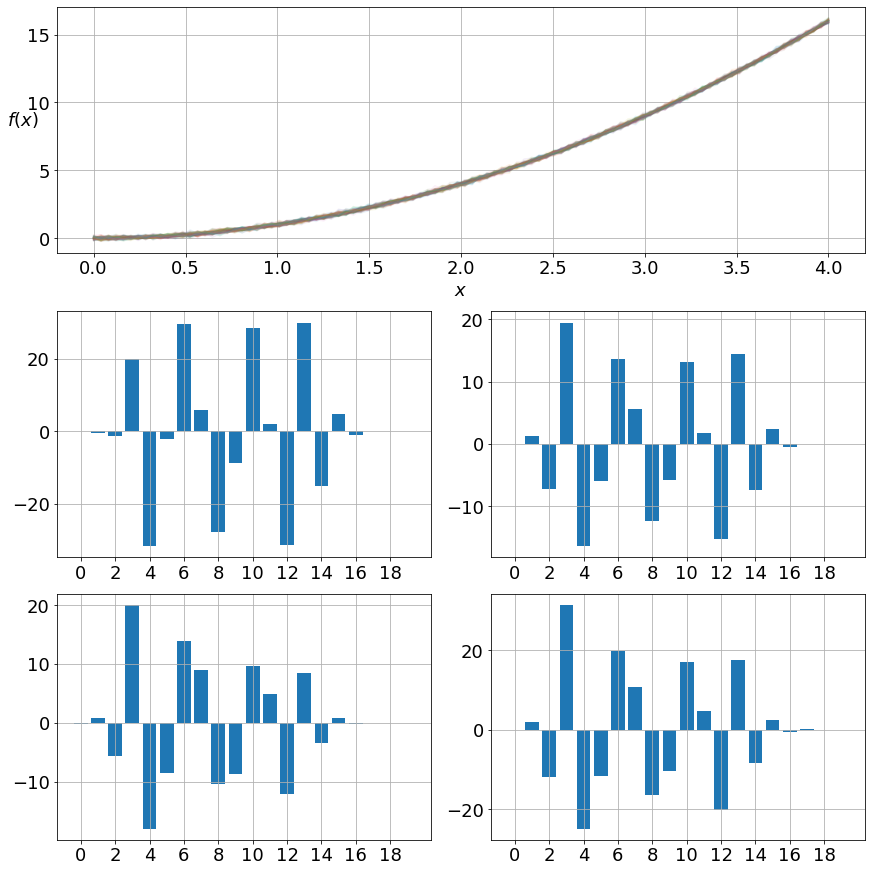

In [3]:
# Figure 4.13

fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(3, 2)
axs = [
    fig.add_subplot(gs[0, :]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[1, 1]),
    fig.add_subplot(gs[2, 0]),
    fig.add_subplot(gs[2, 1]),    
]

for f in fs:
    axs[0].plot(x, f, alpha=0.1)
    axs[0].set_xlabel('$x$')
    axs[0].set_ylabel('$f(x)$', rotation=0)

for ax, an in zip(axs[1:], ans):
    ax.bar(range(len(an)), an)
    ax.set_xticks(range(0, len(an), 2))

for ax in axs:
    ax.grid(True)

In [4]:
## Different regressions

# The matlab examples are:
# - pinv
# - backslash - qr decomposition
# - standard lasso with λ = 0.1
# - elastic net with λ = 0.08, α = 0.02 (ie "total" regularisation = 0.1)
# - robustfit - least squares with bisquare weight (aka biweight) |r|<1 * (1 - r**2)**2
# - ridge α = 0.5, unscaled

# regularisation coefficient for lasso and elastic net (called α here rather than λ as in matlab) 
α = 0.1
Φ2 = Φ[:, 1:]
E1, E2, E3, E4, E5, E6 = np.zeros([6, 100])
A1, A2, A3, A4, A5, A6 = np.zeros([6, M, 100])

fs = []
for i in range(100):
    f = x**2 + 0.2*randn(n)
    fs.append(f)
    
    # pseudo-inverse (svd)
    a1 = pinv(Φ) @ f
    f1 = Φ @ a1
    E1[i] = norm(f - f1) / norm(f)
    
    # something like matlab backslash ?
    a2 = lstsq(Φ, f, rcond=None)[0]
    f2 = Φ @ a2
    E2[i] = norm(f - f2) / norm(f)
    
    # pure lasso
    a3 = ElasticNet(
        alpha=α, copy_X=True, l1_ratio=1.0, max_iter=1e4, random_state=0, normalize=True
    ).fit(Φ, f).coef_
    f3 = Φ @ a3
    E3[i] = norm(f - f3) / norm(f)

    # elastic net
    a4 = ElasticNet(
        alpha=α, copy_X=True, l1_ratio=0.8, max_iter=1e4, random_state=0, normalize=True
    ).fit(Φ, f).coef_
    f4 = Φ @ a4
    E4[i] = norm(f - f4) / norm(f)

    # for some reason in these last two examples the constant term is dropped
    # statsmodels robust linear model (cf matlab robustfit)
    a5 = RLM(f, Φ[:, 1:], M=TukeyBiweight()).fit().params
    a5 = np.insert(a5, 0, 0)
    f5 = Φ @ a5
    E5[i] = norm(f - f5) / norm(f)

    # ridge regression
    a6 = Ridge(alpha=0.5).fit(Φ[:, 1:], f).coef_
    a6 = np.insert(a6, 0, 0)
    f6 = Φ @ a6
    E6[i] = norm(f - f6) / norm(f)

    A1[:, i] = a1
    A2[:, i] = a2
    A3[:, i] = a3
    A4[:, i] = a4
    A5[:, i] = a5
    A6[:, i] = a6

Es = np.column_stack((E1, E2, E3, E4, E5, E6))

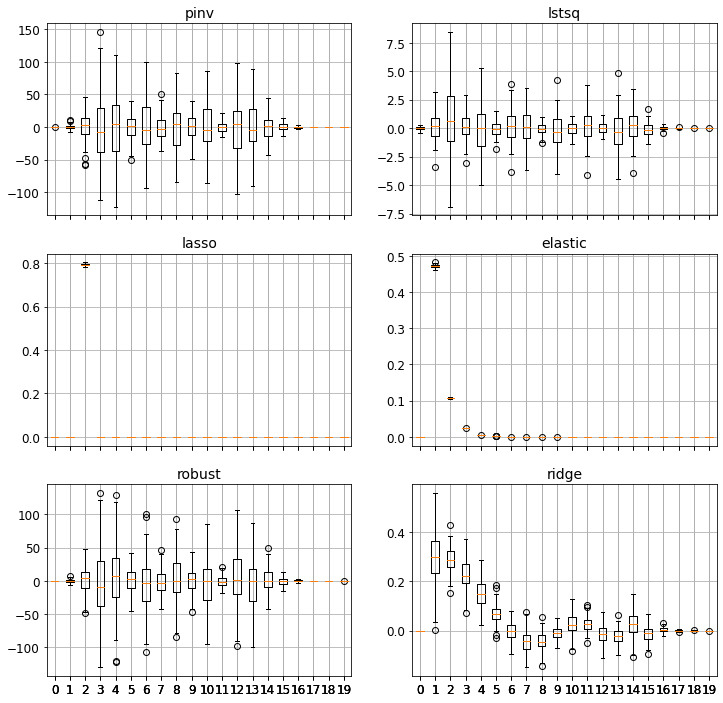

In [5]:
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(3, 2, sharex='col', figsize=(12, 12))
As = [A1, A2, A3, A4, A5, A6]
titles =  ['pinv', 'lstsq', 'lasso', 'elastic', 'robust', 'ridge']
for ax, A, title in zip(axs.flat, As, titles):
    ax.boxplot(A.T, labels=np.arange(M))
    ax.set_title(title, fontsize=14)
    ax.grid(True)

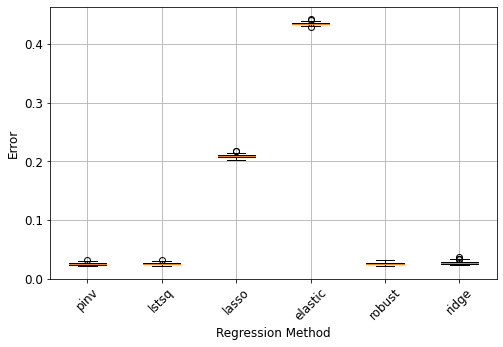

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.boxplot(Es, labels=titles)
ax.set_xticklabels(titles, rotation=45)
ax.grid(True)
ax.set_xlabel('Regression Method')
ax.set_ylabel('Error');

In [7]:
M = 10  # orders
N = 100 # simulations
En = np.zeros((N, M))
f = x**2        
for i in range(M):
    Φ = x[:, np.newaxis] ** np.arange(i+1)[np.newaxis, :]
    for j in range(N):
        fn = f + 0.1*randn(len(f))
        fna = Φ @ (pinv(Φ) @ fn)
        En[j, i] = norm(f - fna) / norm(f)

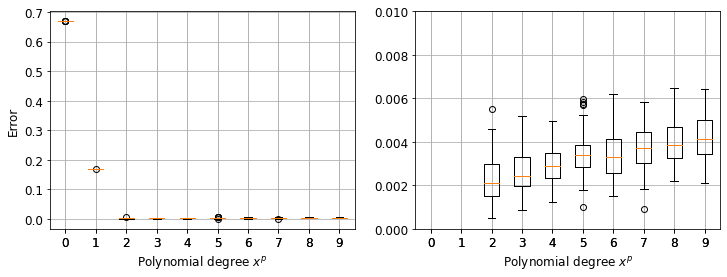

In [8]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(12, 4))
axs[0].boxplot(En, labels=np.arange(M))
axs[0].grid(True)
axs[0].set_xlabel(r'Polynomial degree $x^p$')
axs[0].set_ylabel('Error');
axs[1].boxplot(En, labels=np.arange(M))
axs[1].grid(True)
axs[1].set_xlabel(r'Polynomial degree $x^p$')
axs[1].set_ylim([0, 1e-2]);